<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/SexistCommentDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
import re
import collections

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential,model_from_json, load_model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, Dropout, Bidirectional, Conv1D, BatchNormalization, Masking

## Loading data

In [2]:
data_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/ISEP Sexist Data labeling.xlsx'
data  = pd.read_excel(data_path)

In [3]:
data.head()

,Sentences,Label
0,"For a woman, that is good",1
1,Just dress sexy and you will sign any contract.,1
2,Are you having period ?,1
3,Stop being bitchy,1
4,I leave early because of her children instead ...,1


In [4]:
def clean_data(df):
  df.Sentences = [element.lower() for element in df.Sentences]
  df.Sentences = [re.sub(r'[^a-zA-Z /n]', '', element) for element in df.Sentences]
  # df.Sentences = ['<s> '+ element + ' </s>' for element in df.Sentences]
  return df

In [5]:
df = clean_data(data)

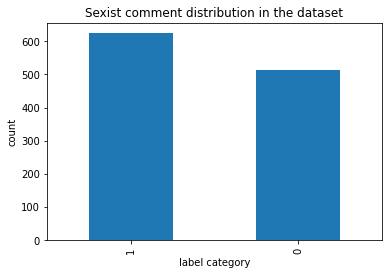

In [6]:
df['Label'].value_counts().plot(kind='bar')
plt.xlabel('label category')
plt.ylabel('count')
plt.title('Sexist comment distribution in the dataset')
plt.show()

## Train-test split

In [7]:
X = df[['Sentences']]
y = df.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state = 66, stratify=y)

In [8]:
# !unzip '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-GNGloVe-300d-0.8-0.8.zip' -d '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/'

### Loading the Gender neutral GLoVe embedding

In [9]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [10]:
embedding_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [11]:
word_to_vec_map['and'].shape

(300,)

In [12]:
vocab = list(words_to_index.keys())

In [13]:
len(vocab)

142527

### Getting word embeddigs for the input data - X_train and X_test

In [14]:
def get_tokens_embedding_list(data, vocab, word_to_vec_map):
  embedding_list = []
  for sent_seq in data:
    tensor_list=[]
    for word in sent_seq[0].split():
      if word in vocab:
        tensor_list.append(word_to_vec_map[word])
        # print(len(tensor_list))
    embedding_list.append(tensor_list)
  return embedding_list

In [15]:
X_train_embedding = get_tokens_embedding_list(X_train.values, vocab, word_to_vec_map)

In [16]:
len(X_train_embedding)

909

In [17]:
np.array(X_train_embedding[0]).shape

(10, 300)

### Define the model

In [18]:
input_layer = Input((None, 300), name='input')
bid_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.5)(bid_lstm_1)
bid_lstm_2 = Bidirectional(LSTM(128, return_sequences=False))(dropout_1)
dropout_2 = Dropout(0.5)(bid_lstm_2)
dense = Dense(1, activation='softmax')(dropout_2)

model = Model(inputs=input_layer, outputs=dense)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         439296    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 833,793
Trainable params: 833,793
Non-trainable params: 0
_______________________________________________________

In [20]:
model.compile(optimizer='adam',  loss='bce', metrics=['accuracy'])

In [21]:
history = model.fit(X_train_embedding, y_train.values, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10


ValueError: ignored

In [24]:
len(X_train_embedding[0][0])

300